# Seismic Travel time Tomography via Fast Marching

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/fmm_tomography/fmm_tomography.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

## 0. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi pyfm2d
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/fmm_tomography

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pprint

import cofi
# NB You will need to separately install pyfm2d in your python environment with `pip install pyfm2d'
import pyfm2d as wt # import fmm package 

In this notebook, we use `cofi` to run a seismic wave tomography example, in which
the forward calculation is based on the Fast Marching Fortran code by Nick
Rawlinson. The Fast Marching code is wrapped in package [pyfm2d](https://github.com/inlab-geo/pyfm2d)

## Theoretical background

In [2]:
# display theory on travel time tomography
from IPython.display import display, Markdown

with open("../../theory/geo_travel_time_tomography.md", "r") as f:
    content = f.read()

display(Markdown(content))

The goal in travel-time tomography is to infer details about the velocity structure of a medium, given measurements of the minimum time taken for a wave to propagate from source to receiver. For seismic travel times, as we change our model, the route of the fastest path from source to receiver also changes. This makes the problem nonlinear, as raypaths also depend on the sought after velocity or slowness model. 

Provided the 'true' velocity structure is not *too* dissimilar from our initial guess, travel-time tomography can be treated as a weakly non-linear problem. In this notebook we optionally treat the ray paths as fixed, and so it becomes a linear problem, or calculate rays in the velociuty model.

The travel-time of an individual ray can be computed as $$t = \int_\mathrm{path} \frac{1}{v(\mathbf{x})}\,\mathrm{d}\mathbf{x}$$
This points to an additional complication: even for a fixed path, the relationship between velocities and observations is not linear. However, if we define the 'slowness' to be the inverse of velocity, $s(\mathbf{x}) = v^{-1}(\mathbf{x})$, we can write
$$t = \int_\mathrm{path} {s(\mathbf{x})}\,\mathrm{d}\mathbf{x}$$
which *is* linear.


We will assume that the object we are interested in is 2-dimensional slowness field. If we discretize this model, with $N_x$ cells in the $x$-direction and $N_y$ cells in the $y$-direction, we can express $s(\mathbf{x})$ as an $N_x \times N_y$ vector $\boldsymbol{s}$. 

**For the linear case**, this is related to the data by
$$d_i = A_{ij}s_j $$
where $d_i$ is the travel time of the ith path, and where $A_{ij}$ represents the path length in cell $j$ of the discretized model.

**For the nonlinear case**, this is related to the data by
$$\delta d_i = A_{ij}\delta s_j $$
where $\delta d_i$ is the difference in travel time, of the ith path, between the observed time and the travel time in the reference model. Here $A_{ij}$ represents the path length in cell $j$ of the discretized model. The parameters $\delta s_j$ are slowness perturbations to the reference model.


In this notebook we form and solve a travel time tomography problem using model damping and 2nd derivative smoothing. For forward modelling, a fast marching wave front tracker is used, utilizing the Fast Marching Fortran code within the package [`FMTOMO`](http://iearth.edu.au/codes/FMTOMO/) by Nick Rawlinson. The Fast Marching code is wrapped in package [pyfm2d](https://github.com/inlab-geo/pyfm2d). Further details can be found in:

- Rawlinson, N., de Kool, M. and Sambridge, M., 2006. Seismic wavefront tracking in 3-D heterogeneous media: applications with multiple data classes, Explor. Geophys., 37, 322-330.
- Rawlinson, N. and Urvoy, M., 2006. Simultaneous inversion of active and passive source datasets for 3-D seismic structure with application to Tasmania, Geophys. Res. Lett., 33 L24313, 10.1029/2006GL028105.
- de Kool, M., Rawlinson, N. and Sambridge, M. 2006. A practical grid based method for tracking multiple refraction and reflection phases in 3D heterogeneous media, Geophys. J. Int., 167, 253-270.
- Saygin, E. 2007. Seismic receiver and noise correlation based studies in Australia, PhD thesis, Australian National University, 10.25911/5d7a2d1296f96.

### Problem setup

Before we starting working with `cofi`, let's get familiar with the problem itself.

Below is a plot of the true model and the paths generated from this model. As you can see,
there are two anomalies, one with lower velocity (red, top left) and the other with higher
velocity (blue, bottom right).

In [3]:
# read in problem data
loaded_dict = np.load('../../data/travel_time_tomography/nonlinear_tomo_example.npz')
nonlinear_tomo_example = dict(loaded_dict)
loaded_dict.close()

In [4]:
# set up problem
good_model = nonlinear_tomo_example["_mtrue"]
extent = nonlinear_tomo_example["extent"]
sources = nonlinear_tomo_example["sources"]
receivers = nonlinear_tomo_example["receivers"]
obstimes = nonlinear_tomo_example["_data"]
print(' New data set have:\n',len(receivers),' receivers\n',len(sources),' sources\n',len(obstimes),' travel times\n',
'Range of travel times: ',np.min(obstimes),'to',np.max(obstimes),'\n Mean travel time:',np.mean(obstimes))

 New data set have:
 10  receivers
 10  sources
 100  travel times
 Range of travel times:  0.009490006 to 0.01558705 
 Mean travel time: 0.011210016954999999


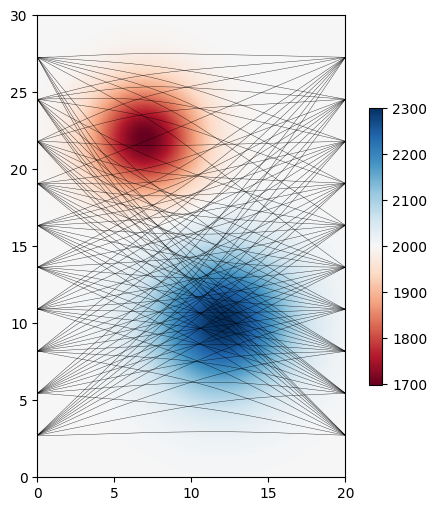

In [5]:
# display true model and raypaths
options = wt.WaveTrackerOptions(paths=True,cartesian=True) # set wavetracker options
result = wt.calc_wavefronts(good_model,receivers,sources,extent=extent, options=options) # track wavefronts
wt.display_model(good_model,paths=result.paths,extent=extent,line=0.3,alpha=0.82)

## 1. Define the problem

In [6]:
# get problem information 
model_size = good_model.size                           # number of model parameters
model_shape = good_model.shape                         # 2D spatial grid shape
data_size = data_size = len(obstimes)                  # number of data
ref_start_slowness = nonlinear_tomo_example["_sstart"] # use the starting guess supplied by the nonlinear example

In [7]:
# define CoFI BaseProblem
fmm_problem = cofi.BaseProblem()
fmm_problem.set_initial_model(ref_start_slowness.flatten())

In [8]:
# add regularization: damping + smoothing
damping_factor = 50
smoothing_factor = 5e3
reg_damping = damping_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape, 
    weighting_matrix="damping", 
    reference_model=ref_start_slowness
)
reg_smoothing = smoothing_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape,
    weighting_matrix="smoothing"
)
reg = reg_damping + reg_smoothing

In [9]:
def objective_func(slowness, reg, sigma, reduce_data=None):  # reduce_data=(idx_from, idx_to)
    if reduce_data is None: idx_from, idx_to = (0, data_size)
    else: idx_from, idx_to = reduce_data
    if(True):
        options = wt.WaveTrackerOptions(
            cartesian=True,
        )
        result = wt.calc_wavefronts(1./slowness.reshape(model_shape),receivers,sources,extent=extent,options=options) # track wavefronts
        ttimes = result.ttimes
    residual = obstimes[idx_from:idx_to] - ttimes[idx_from:idx_to]
    data_misfit = residual.T @ residual / sigma**2
    model_reg = reg(slowness)
    return  data_misfit + model_reg

def gradient(slowness, reg, sigma, reduce_data=None):       # reduce_data=(idx_from, idx_to)
    if reduce_data is None: idx_from, idx_to = (0, data_size)
    else: idx_from, idx_to = reduce_data
    if(True):
        options = wt.WaveTrackerOptions(
                    paths=True,
                    frechet=True,
                    cartesian=True,
                    )
        result = wt.calc_wavefronts(1./slowness.reshape(model_shape),receivers,sources,extent=extent,options=options) # track wavefronts
        ttimes = result.ttimes
        A = result.frechet.toarray()
    ttimes = ttimes[idx_from:idx_to]
    A = A[idx_from:idx_to]
    data_misfit_grad = -2 * A.T @ (obstimes[idx_from:idx_to] - ttimes) / sigma**2
    model_reg_grad = reg.gradient(slowness)
    return  data_misfit_grad + model_reg_grad

def hessian(slowness, reg, sigma, reduce_data=None):        # reduce_data=(idx_from, idx_to)
    if reduce_data is None: idx_from, idx_to = (0, data_size)
    else: idx_from, idx_to = reduce_data
    if(True):
        options = wt.WaveTrackerOptions(
                    paths=True,
                    frechet=True,
                    cartesian=True,
                    )
        result = wt.calc_wavefronts(1./slowness.reshape(model_shape),receivers,sources,extent=extent,options=options)
        A = result.frechet.toarray()
    A = A[idx_from:idx_to]
    data_misfit_hess = 2 * A.T @ A / sigma**2 
    model_reg_hess = reg.hessian(slowness)
    return data_misfit_hess + model_reg_hess

In [10]:
sigma = 0.000008          # data standard deviation of noise

fmm_problem.set_objective(objective_func, args=[reg, sigma, None])
fmm_problem.set_gradient(gradient, args=[reg, sigma, None])
fmm_problem.set_hessian(hessian, args=[reg, sigma, None])

Review what information is included in the `BaseProblem` object:

In [11]:
fmm_problem.summary()

Summary for inversion problem: BaseProblem
Model shape: (1536,)
---------------------------------------------------------------------
List of functions/properties set by you:
['objective', 'gradient', 'hessian', 'initial_model', 'model_shape']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['hessian_times_vector']
---------------------------------------------------------------------
List of functions/properties that can be further set for the problem:
( not all of these may be relevant to your inversion workflow )
['log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'hessian_times_vector', 'residual', 'jacobian', 'jacobian_times_vector', 'data_misfit', 'regularization', 'regularization_matrix', 'forward', 'data', 'data_covariance', 'data_covariance_inv', 'blobs_dtype', 'bounds', 'constraints']


## 2. Define the inversion options

In [12]:
my_options = cofi.InversionOptions()

# cofi's own simple newton's matrix-based optimization solver
my_options.set_tool("cofi.simple_newton")
my_options.set_params(num_iterations=5, step_length=1, verbose=True)

Review what's been defined for the inversion we are about to run:

In [13]:
my_options.summary()

Summary for inversion options
Solving method: None set
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `<class 'cofi.tools._cofi_simple_newton.CoFISimpleNewton'>` - CoFI's own solver - simple Newton's approach (for testing mainly)
References: ['https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: 
num_iterations = 5
step_length = 1
verbose = True
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


## 3. Start an inversion

In [14]:
inv = cofi.Inversion(fmm_problem, my_options)
inv_result = inv.run()
inv_result.summary()

Iteration #0, updated objective function value: 2231.6300593536093
Iteration #1, updated objective function value: 36.312292569140936
Iteration #2, updated objective function value: 2.058777871392014
Iteration #3, updated objective function value: 0.18155070622777428
Iteration #4, updated objective function value: 0.1330315517951554
Summary for inversion result
SUCCESS
----------------------------
model: [0.00048691 0.00048376 0.00048083 ... 0.00050077 0.0005008  0.00050084]
num_iterations: 4
objective_val: 0.1330315517951554
n_obj_evaluations: 6
n_grad_evaluations: 5
n_hess_evaluations: 5


## 4. Plotting

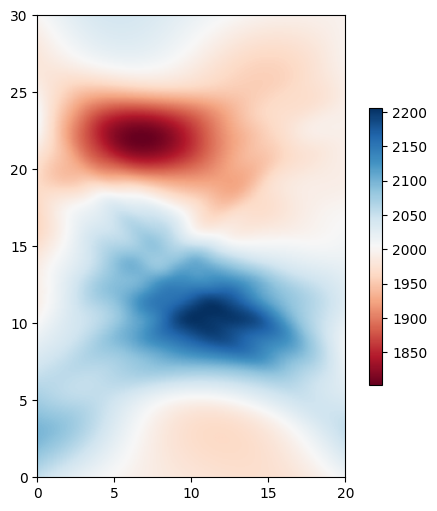

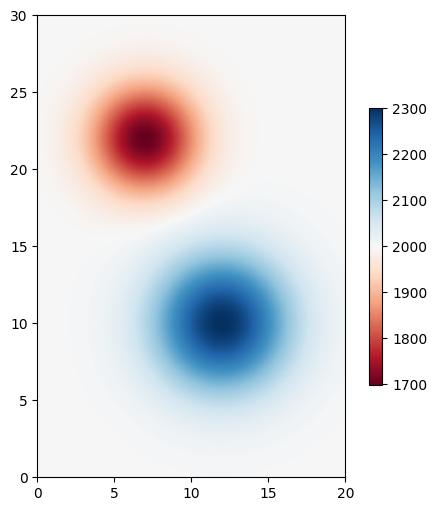

In [15]:
#fmm.plot_model(inv_result.model);            # inverted model
#fmm.plot_model(fmm.good_model);       # true model
vmodel_inverted = 1./inv_result.model.reshape(model_shape)
wt.display_model(vmodel_inverted,extent=extent) # inverted model
wt.display_model(good_model,extent=extent) # true model

---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [16]:
watermark_list = ["cofi", "numpy", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.10
numpy 2.3.5
matplotlib 3.10.7
